In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Load the Excel file
file_path = '../data/sirs_demo_abc_clean'
df = pd.read_pickle(file_path)

In [2]:
# Convert 'Date Reviewed' column to datetime, ignoring errors
df['Date Reviewed'] = pd.to_datetime(df['Date Reviewed'], errors='coerce')

# Drop rows with invalid or missing dates
df = df.dropna(subset=['Date Reviewed'])

# Define the COVID-19 onset date
covid_onset_date = pd.Timestamp('2020-03-13')

In [3]:
# Function to analyze differences by race
def analyze_by_race(race):
    race_data = df[df['race_clean'] == race]
    
    # Separate data into before and after COVID-19
    before_covid_data = race_data[race_data['Date Reviewed'] < covid_onset_date]
    after_covid_data = race_data[race_data['Date Reviewed'] >= covid_onset_date]

    # Further separate into Intake and Re-evaluation for both periods
    before_covid_intake = before_covid_data[before_covid_data['Type of Service'] == 'Intake']
    before_covid_reevaluation = before_covid_data[before_covid_data['Type of Service'] == 'Re-evaluation']

    after_covid_intake = after_covid_data[after_covid_data['Type of Service'] == 'Intake']
    after_covid_reevaluation = after_covid_data[after_covid_data['Type of Service'] == 'Re-evaluation']

    # Calculate the mean scores for each behavior at Intake and Re-evaluation for both periods
    before_covid_intake_means = before_covid_intake.mean(numeric_only=True)
    before_covid_reevaluation_means = before_covid_reevaluation.mean(numeric_only=True)

    after_covid_intake_means = after_covid_intake.mean(numeric_only=True)
    after_covid_reevaluation_means = after_covid_reevaluation.mean(numeric_only=True)

    # Combine the means into DataFrames for comparison
    before_covid_comparison = pd.DataFrame({
        'Intake Mean (Before COVID)': before_covid_intake_means,
        'Re-evaluation Mean (Before COVID)': before_covid_reevaluation_means
    })
    before_covid_comparison['Difference (Before COVID)'] = before_covid_comparison['Intake Mean (Before COVID)'] - before_covid_comparison['Re-evaluation Mean (Before COVID)']

    after_covid_comparison = pd.DataFrame({
        'Intake Mean (After COVID)': after_covid_intake_means,
        'Re-evaluation Mean (After COVID)': after_covid_reevaluation_means
    })
    after_covid_comparison['Difference (After COVID)'] = after_covid_comparison['Intake Mean (After COVID)'] - after_covid_comparison['Re-evaluation Mean (After COVID)']

    # Calculate the change in difference
    change_in_difference = before_covid_comparison['Difference (Before COVID)'] - after_covid_comparison['Difference (After COVID)']
    change_in_difference.name = 'Change in Difference'

    return change_in_difference

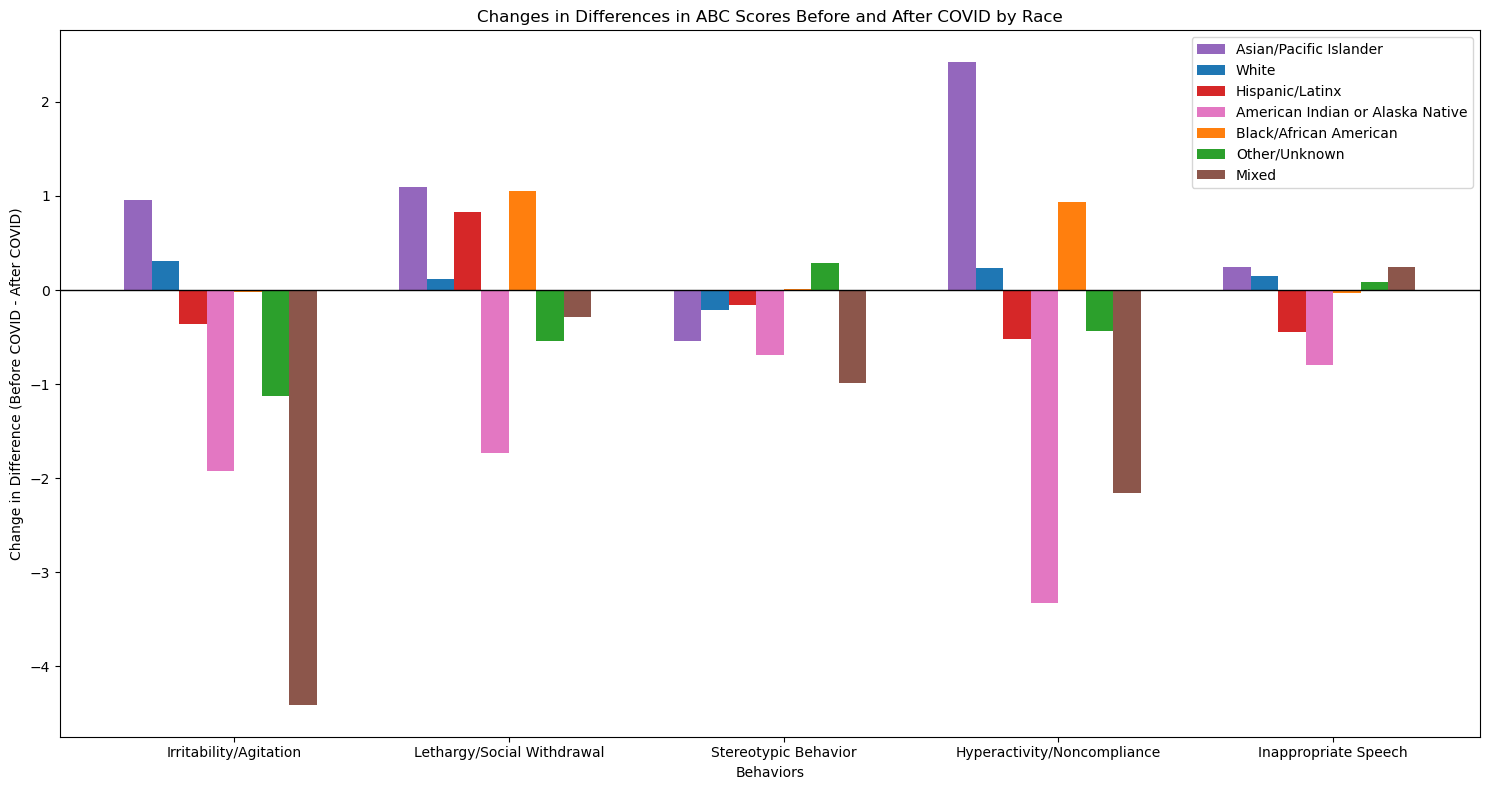

In [11]:
# List of races to analyze
races = df['race_clean'].unique()
behaviors = ['Irritability/Agitation', 'Lethargy/Social Withdrawal', 'Stereotypic Behavior', 'Hyperactivity/Noncompliance', 'Inappropriate Speech']

# Define color mapping for races
colors = {
    'White': '#1f77b4',
    'Black/African American': '#ff7f0e',
    'Other/Unknown': '#2ca02c',
    'Hispanic/Latinx': '#d62728',
    'Asian/Pacific Islander': '#9467bd',
    'Mixed': '#8c564b',
    'American Indian or Alaska Native': '#e377c2',
}

# Plot changes in differences by race for each behavior
plt.figure(figsize=(15, 8))
bar_width = 0.1
index = range(len(behaviors))

for i, race in enumerate(races):
    change_in_difference = analyze_by_race(race)
    
    plt.bar([x + i * bar_width for x in index], change_in_difference, bar_width, color=colors[race], label=race)

# Add labels and title
plt.axhline(0, color='black', linewidth=1, linestyle='-')
plt.xlabel('Behaviors')
plt.ylabel('Change in Difference (Before COVID - After COVID)')
plt.title('Changes in Differences in ABC Scores Before and After COVID by Race')
plt.xticks([x + bar_width * len(races) / 2 for x in index], behaviors, rotation=0)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

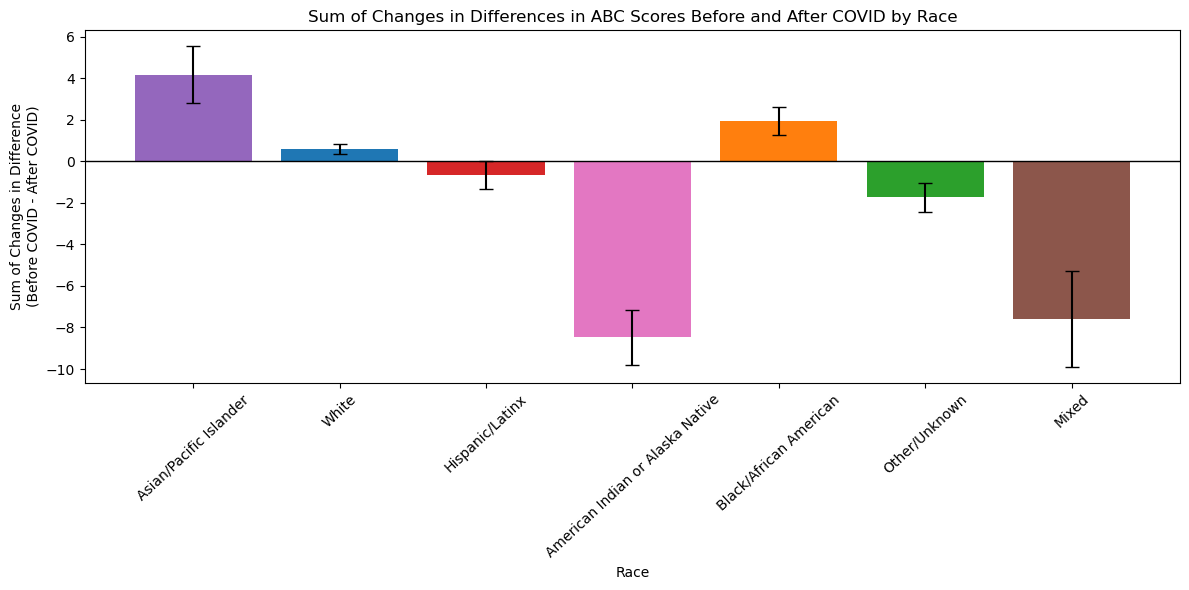

In [13]:
# Filter numeric columns (assuming that the first three columns are non-numeric)
numeric_columns = df.select_dtypes(include=['number']).columns

# Function to analyze differences by race and calculate confidence intervals
def analyze_and_calculate_ci_by_race(race):
    race_data = df[df['race_clean'] == race]
    
    # Separate data into before and after COVID-19
    before_covid_data = race_data[race_data['Date Reviewed'] < covid_onset_date]
    after_covid_data = race_data[race_data['Date Reviewed'] >= covid_onset_date]

    # Further separate into Intake and Re-evaluation for both periods
    before_covid_intake = before_covid_data[before_covid_data['Type of Service'] == 'Intake']
    before_covid_reevaluation = before_covid_data[before_covid_data['Type of Service'] == 'Re-evaluation']

    after_covid_intake = after_covid_data[after_covid_data['Type of Service'] == 'Intake']
    after_covid_reevaluation = after_covid_data[after_covid_data['Type of Service'] == 'Re-evaluation']

    # Calculate the mean scores for each behavior at Intake and Re-evaluation for both periods
    before_covid_intake_means = before_covid_intake[numeric_columns].mean()
    before_covid_reevaluation_means = before_covid_reevaluation[numeric_columns].mean()

    after_covid_intake_means = after_covid_intake[numeric_columns].mean()
    after_covid_reevaluation_means = after_covid_reevaluation[numeric_columns].mean()

    # Combine the means into DataFrames for comparison
    before_covid_comparison = pd.DataFrame({
        'Intake Mean (Before COVID)': before_covid_intake_means,
        'Re-evaluation Mean (Before COVID)': before_covid_reevaluation_means
    })
    before_covid_comparison['Difference (Before COVID)'] = before_covid_comparison['Intake Mean (Before COVID)'] - before_covid_comparison['Re-evaluation Mean (Before COVID)']

    after_covid_comparison = pd.DataFrame({
        'Intake Mean (After COVID)': after_covid_intake_means,
        'Re-evaluation Mean (After COVID)': after_covid_reevaluation_means
    })
    after_covid_comparison['Difference (After COVID)'] = after_covid_comparison['Intake Mean (After COVID)'] - after_covid_comparison['Re-evaluation Mean (After COVID)']

    # Calculate the change in difference
    change_in_difference = before_covid_comparison['Difference (Before COVID)'] - after_covid_comparison['Difference (After COVID)']

    # Sum the changes in difference across all behaviors
    sum_change_in_difference = change_in_difference.sum()

    # Calculate the confidence interval
    n = len(change_in_difference)
    std_err = stats.sem(change_in_difference)
    h = std_err * stats.t.ppf((1 + 0.95) / 2, n - 1)

    return sum_change_in_difference, h

# List of races to analyze
races = df['race_clean'].unique()

# Calculate the sum of changes in differences and confidence intervals for each race
sum_changes_ci_by_race = {race: analyze_and_calculate_ci_by_race(race) for race in races}

# Convert the result to a DataFrame for plotting
sum_changes_df = pd.DataFrame(sum_changes_ci_by_race, index=['Sum of Changes', 'CI']).T

# Define color mapping for races
colors = {
    'White': '#1f77b4',
    'Black/African American': '#ff7f0e',
    'Other/Unknown': '#2ca02c',
    'Hispanic/Latinx': '#d62728',
    'Asian/Pacific Islander': '#9467bd',
    'Mixed': '#8c564b',
    'American Indian or Alaska Native': '#e377c2',
}

# Plot the sums of changes in differences by race with specified colors and confidence intervals
plt.figure(figsize=(12, 6))
bars = plt.bar(sum_changes_df.index, sum_changes_df['Sum of Changes'], color=[colors[race] for race in sum_changes_df.index], yerr=sum_changes_df['CI'], capsize=5)
plt.axhline(0, color='black', linewidth=1, linestyle='-')

# Add labels and title
plt.xlabel('Race')
plt.ylabel('Sum of Changes in Difference\n(Before COVID - After COVID)')
plt.title('Sum of Changes in Differences in ABC Scores Before and After COVID by Race')
plt.xticks(rotation=43)
plt.tight_layout()

# Display the plot
plt.show()